#### exploration of the hexconv step starting from an event

In [1]:
import os
from os import path
import pandas as pd
import tables
from uuid import uuid4
import csv
import numpy as np
import matplotlib.pyplot as plt

#### read the event

In [2]:
path_local = "/home/bapanes/Research-Now/local/ml-valpo-local"

#umonna_h5 = f"{path_local}/umonna/events/gamma_20deg_0deg_runs3977-4937___cta-prod3-demo_desert-2150m-Paranal-baseline_cone10.h5"
umonna_h5 = f"{path_local}/umonna/events/gamma_20deg_0deg_runs2-1422___cta-prod3-demo_desert-2150m-Paranal-baseline_cone10.h5"

#h5_file_train = tables.open_file(train_files[1], "r")
h5_file_train = tables.open_file(umonna_h5, "r")

train_files = [h5_file_train]

print("Tables:")
for t in h5_file_train.root:
    print("\t",t)

Tables:
	 /Array_Information (Table(99,), shuffle, lzo(1)) 'Table of array/subarray information'
	 /Events (Table(8521,), shuffle, lzo(1)) 'Table of Event Information'
	 /LST_LSTCam (Table(4103,), shuffle, lzo(1)) 'Table of LST:LSTCam images'
	 /MST_FlashCam (Table(18941,), shuffle, lzo(1)) 'Table of MST:FlashCam images'
	 /SST1M_DigiCam (Table(14099,), shuffle, lzo(1)) 'Table of SST-1M:DigiCam images'
	 /Telescope_Type_Information (Table(3,), shuffle, lzo(1)) 'Table of telescope type information'


#### routines

In [16]:
output_shapes = {
    # Train|Test
    "LST_LSTCam" : (2, 55, 47, 3),
    "SST1M_DigiCam" : (2, 72, 25, 3),
    "MST_FlashCam" : (2, 84, 29, 3),
}

peak_shapes = {
    # Train|Test
    # (energy_peak, time_peak)
    "LST_LSTCam" : (1855, 2),
    "SST1M_DigiCam" : (1296, 2),
    "MST_FlashCam" : (1764, 2),
}

def hexagon_to_matrix(charge, time_peaks, tel_type, pixel_position_folder):
    """
    __hexagon_save
        TODO: docstring
    """
    __pixels_position = np.loadtxt(f"{pixel_position_folder}/{tel_type}.npy")
    
    # get pixels positions
    x = __pixels_position[0,:]
    y = __pixels_position[1,:]

    # indices of x and y pixels position
    i = np.arange(0, len(y))

    # row values of the telescope
    y_levels = np.sort(np.unique(y))

    # image dimension
    nrows = len(y_levels)
    ncols = len(np.unique(x))//2 + 1

    # new translated pixel positions
    new_x_l = np.copy(x) # new pixels x positions left shift
    new_x_r = np.copy(x) # new pixels x positions right shift
    new_y = np.copy(y)

    # shift odd rows
    dx = 0
    for level, y_value in enumerate(y_levels):
        indices = i[y == y_value]
        if dx == 0:
            dx = np.diff(np.sort(x[indices])).min()/2
        if level % 2 != 0:
            new_x_l[indices] -= dx
            new_x_r[indices] += dx

    # round values
    new_x_l = np.round(new_x_l, 3)
    new_x_r = np.round(new_x_r, 3)

    # max indices of image output
    max_col_l = len(np.unique(new_x_l)) - 1
    max_col_r = len(np.unique(new_x_r)) - 1
    max_row = nrows - 1

    # apply lineal transfomation
    new_x_l = ((max_col_l/(new_x_l.max() - new_x_l.min())) * (new_x_l - new_x_l.min()))
    new_x_l = np.round(new_x_l).astype(int)

    new_x_r = ((max_col_r/(new_x_r.max() - new_x_r.min())) * (new_x_r - new_x_r.min()))
    new_x_r = np.round(new_x_r).astype(int)

    new_y = ((max_row/(new_y.max() - new_y.min())) * (new_y - new_y.min()))
    new_y = np.round(new_y).astype(int)

    # Save indices
    pix_pos = np.vstack((new_x_l, new_x_r, new_y)).T
    
    # Save Peak and Time
    values = np.vstack((charge, time_peaks)).T
    
    return pix_pos, values

def scatter_hexagon(data, title=""):
    plt.figure(figsize=(12,10))
    plt.suptitle(title)

    plt.subplot(231)
    plt.title("charge (left)")
    plt.imshow(data[0,:,:,0])

    plt.subplot(232)
    plt.title("time peak (left)")
    plt.imshow(data[0,:,:,1])

    plt.subplot(233)
    plt.title("mask (left)")
    plt.imshow(data[0,:,:,2])

    plt.subplot(234)
    plt.title("charge (right)")
    plt.imshow(data[1,:,:,0])

    plt.subplot(235)
    plt.title("time peak (right)")
    plt.imshow(data[1,:,:,1])

    plt.subplot(236)
    plt.title("mask (right)")
    plt.imshow(data[1,:,:,2])
    plt.show()
    
def generate_matrix_data(pix_pos_matrix, values):

    # preprare new canvas
    new_x_l =  pix_pos_matrix[:,0]
    new_x_r =  pix_pos_matrix[:,1]
    new_y =  pix_pos_matrix[:,2]

    #canvas = np.zeros(output_shapes[tel_type], dtype="float32")
    canvas = np.zeros(output_shapes[tel_type], dtype="float32")

    peaks = values[:,:]
    mask = np.ones((len(peaks), 1), dtype="float32")

    # left shift canvas
    canvas[0, new_y, new_x_l, :2] = peaks[:,:]
    canvas[0, new_y, new_x_l, 2] = mask[:,0]

    # rigth shift canvas
    canvas[1, new_y, new_x_r, :2] = peaks[:,:]
    canvas[1, new_y, new_x_r, 2] = mask[:,0]
    
    return canvas

#### create and save numpy file with the raw pixels from one telescope

In [4]:
tel_info = h5_file_train.root["Telescope_Type_Information"]
tel_info.cols

/Telescope_Type_Information.cols (Cols), 5 columns
  camera (Column(3,), |S20)
  num_pixels (Column(3,), uint32)
  optics (Column(3,), |S20)
  pixel_positions (Column(3, 1855, 2), ('<f4', (1855, 2)))
  type (Column(3,), |S20)

In [5]:
element = 2

for element in range(3):
    print("telescope info element: ", element)
    print(tel_info[element]["type"])
    print(tel_info[element]["camera"])
    print(tel_info[element]["optics"])
    print(tel_info[element]["num_pixels"])

telescope info element:  0
b'SST1M_DigiCam'
b'DigiCam'
b'SST-1M'
1296
telescope info element:  1
b'MST_FlashCam'
b'FlashCam'
b'MST'
1764
telescope info element:  2
b'LST_LSTCam'
b'LSTCam'
b'LST'
1855


#### for instance, let us consider the pixels of telescope 0

In [24]:
element = 0

tel_type = tel_info[element]["type"].decode("utf-8") 
pixeles = np.transpose(tel_info[element]["pixel_positions"][:tel_info[element]["num_pixels"]])

np.savetxt(f"pixels_position/{tel_type}.npy", pixeles)

print(f"pixels_position/{tel_type}.npy", pixeles)

pixels_position/SST1M_DigiCam.npy [[ 0.4837   0.46327  0.46327 ... -0.45645 -0.47689 -0.47689]
 [-0.0118  -0.0472  -0.0236  ...  0.0354  -0.0236   0.     ]]


#### now we access to the information of one event

In [7]:
events = h5_file_train.root["Events"]

print("Events:", len(events))
events.cols

Events: 8521


/Events.cols (Cols), 16 columns
  LST_LSTCam_indices (Column(8521, 4), ('<u4', (4,)))
  LST_LSTCam_multiplicity (Column(8521,), uint32)
  MST_FlashCam_indices (Column(8521, 25), ('<u4', (25,)))
  MST_FlashCam_multiplicity (Column(8521,), uint32)
  SST1M_DigiCam_indices (Column(8521, 70), ('<u4', (70,)))
  SST1M_DigiCam_multiplicity (Column(8521,), uint32)
  alt (Column(8521,), float32)
  az (Column(8521,), float32)
  core_x (Column(8521,), float32)
  core_y (Column(8521,), float32)
  event_id (Column(8521,), uint32)
  h_first_int (Column(8521,), float32)
  mc_energy (Column(8521,), float32)
  obs_id (Column(8521,), uint32)
  shower_primary_id (Column(8521,), uint8)
  x_max (Column(8521,), float32)

In [8]:
event = events[10]
event_number =  str(event['event_id']) + "_" + uuid4().hex[:8]

print("event id: ",event_number)

event id:  140211_076593a0


#### each event also gives us a list of indices to find the proper images in the corresponding telescope

In [9]:
tel_indice = f"LST_LSTCam_indices"
print(tel_indice)

print("Non-zero are activated telescopes, the number is not the telescope index. Instead, is the "+\
      "image (observation) index.")
print("Telescopes:", event[tel_indice])
print(len(event[tel_indice]))

LST_LSTCam_indices
Non-zero are activated telescopes, the number is not the telescope index. Instead, is the image (observation) index.
Telescopes: [0 0 0 0]
4


In [10]:
tel_indice = f"SST1M_DigiCam_indices"
print(tel_indice)

print("Non-zero are activated telescopes, the number is not the telescope index. Instead, is the "+\
      "image (observation) index.")
print("Telescopes:", event[tel_indice])
print(len(event[tel_indice]))

SST1M_DigiCam_indices
Non-zero are activated telescopes, the number is not the telescope index. Instead, is the image (observation) index.
Telescopes: [ 0  0  0 40  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
70


In [11]:
tel_indice = f"MST_FlashCam_indices"
print(tel_indice)

print("Non-zero are activated telescopes, the number is not the telescope index. Instead, is the "+\
      "image (observation) index.")
print("Telescopes:", event[tel_indice])
print(len(event[tel_indice]))

MST_FlashCam_indices
Non-zero are activated telescopes, the number is not the telescope index. Instead, is the image (observation) index.
Telescopes: [ 0  0  0  0  0  0  0  0  0  0  0 54  0  0  0  0  0  0 55  0  0  0  0 56
  0]
25


#### now, from a given telescope we get one of the indices of the event

In hexagon_to_matrix we get the conversion of the pixels from hexagon to matrix 

In [20]:
tel_type = "SST1M_DigiCam"
indice = 41

#charge distribution from the main variable that refers to the file
charge_peaks = h5_file_train.root[tel_type][indice]["charge"]
time_peaks = h5_file_train.root[tel_type][indice]["peakpos"]

In [25]:
pix_pos_matrix, charge_time_peaks = hexagon_to_matrix(charge_peaks, time_peaks, tel_type, "pixels_position/")

#### creation of left and right images

In [26]:
input_data_matrix = generate_matrix_data(pix_pos_matrix, charge_time_peaks)

print(input_data_matrix.shape)

(2, 72, 25, 3)


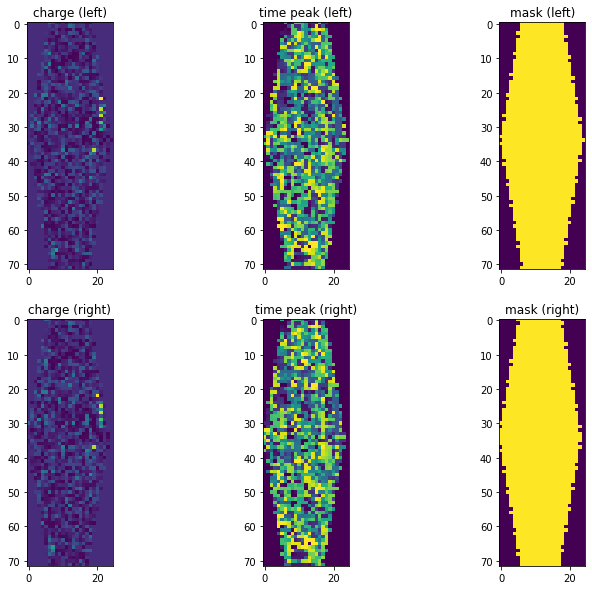

In [27]:
scatter_hexagon(input_data_matrix, title="")